## Create environment


In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install torch torchvision lightning torchmetrics
!pip install -U --no-deps pytorch-optimizer
!pip install pytorch_lightning wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
import os
import json
f = open("/content/gdrive/MyDrive/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [4]:
!kaggle datasets download -d soumikrakshit/nyu-depth-v2
os.listdir()

100% 4.09G/4.10G [00:48<00:00, 72.4MB/s]
100% 4.10G/4.10G [00:48<00:00, 91.4MB/s]


['.config', 'nyu-depth-v2.zip', 'gdrive', 'sample_data']

In [5]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/ENNCA/nyu-depth-v2.zip' -d '/content/';

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/32.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/32.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/33.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/33.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/34.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/34.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/35.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/35.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/36.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/36.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/37.jpg  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/37.png  
  inflating: /content/nyu_data/data/nyu2_train/playroom_0004_out/38.jpg  
  infl

In [22]:
from os import cpu_count
import random

import torch
from torch import nn, cat
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision.utils import make_grid
import torchvision.models as models

import lightning.pytorch as pl
from torchmetrics import StructuralSimilarityIndexMeasure

from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pytorch_optimizer import Adan

random.seed(42)
torch.manual_seed(42)

## Dataset

* On initialization (__init__), it accepts a root directory path, a CSV file path, and a flag indicating whether to apply transformations to the images. The CSV file is expected to contain pairs of image paths which are read into the samples attribute.

* The __getitem__ method takes an index and returns a tuple containing two tensors: one for the input image and one for the target image. These images are loaded from the paths defined in the samples attribute. They are converted to tensors, normalized and resized to 224x224. If the apply_transforms flag is set to True, additional transformations such as color jittering, horizontal flipping, normalization, and stacking are applied. Finally, the target tensor is resized to 56x56 before being returned.

* The __len__ method simply returns the total number of image pairs available in the dataset.






In [38]:
class NyuDataset(Dataset):
    def __init__(self, root, csv, apply_transforms=True):
        self.apply_transforms = apply_transforms
        with open(f'{root}{csv}') as f:
            self.samples = list(
                map(
                    lambda pair: list(
                        map(
                            lambda path: f'{root}{path}',
                            pair.strip().split(','),
                        )
                    ),
                    f.readlines(),
                )
            )

    def __getitem__(self, index):
        input_path, target_path = self.samples[index]
        input_image = Image.open(input_path)
        target_image = Image.open(target_path)
        x_tensor = to_tensor(input_image)
        y_tensor = to_tensor(target_image).float()
        y_tensor = y_tensor / y_tensor.max()
        # reduce the size to make the transforms less expensive
        x_tensor = resize(x_tensor, size=[224, 224], antialias=True)
        if self.apply_transforms:
            # reduce the targets to stack them later
            y_tensor = resize(y_tensor, size=[224, 224], antialias=True)
            input_image = T.ColorJitter()(input_image)
            t = T.Compose(
                [
                    T.RandomHorizontalFlip(),
                    T.ColorJitter(),
                    T.Normalize(0, 1)
                ]
            )
            # stack and apply the same transformations to both
            tensors = cat([x_tensor, y_tensor])
            tensors = t(tensors)
            x_tensor = tensors[0:3]
            y_tensor = tensors[3:]
        y_tensor = resize(y_tensor, size=[56, 56], antialias=True)
        return x_tensor, y_tensor

    def __len__(self):
        return len(self.samples)

This Python code defines a PyTorch Lightning DataModule, NyuDataModule. It loads data from the provided root and CSV files, then splits the dataset into training and validation subsets. It also sets up data loaders for training, validation, and testing.

In [39]:
class NyuDataModule(pl.LightningDataModule):
    def __init__(self, root, csv_train, csv_test, batch_size: int = 32, apply_transforms=True):
        super().__init__()
        dataset = NyuDataset(root, csv_train, apply_transforms)
        self.test = NyuDataset(root, csv_test, apply_transforms)
        proportions = [.7, .3]
        lengths = [int(p * len(dataset)) for p in proportions]
        lengths[-1] = len(dataset) - sum(lengths[:-1])
        self.train, self.val = random_split(dataset, lengths)
        self.batch_size = batch_size
        self.workers = cpu_count()

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=True,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.workers,
            drop_last=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.workers,
        )


In [40]:
def visualize(name, batch, model=None, n=4):
    x, y = batch
    n = min(n, len(x))
    x = x[0:n]
    y = y[0:n]
    if model:
        fig, ax = plt.subplots(nrows=3, ncols=n)
    else:
        fig, ax = plt.subplots(nrows=2, ncols=n)
    fig.suptitle(name)
    for i, axi in enumerate(ax.flat):
        axi.axis(False)
        image = x[i % n]
        target = y[i % n].squeeze()
        if i < n:
            image = image.permute(1,2,0).cpu().numpy()
            axi.imshow((image * 255).astype(np.uint8), cmap='gray');
            if i % n == 0: axi.set_title('original image')
        elif i < 2*n:
            axi.imshow(target.cpu(), cmap='gray');
            if i % n == 0: axi.set_title('real depth')
        else:
            image = image.unsqueeze(0)
            estimated = model(image).detach().squeeze().squeeze()
            axi.imshow(estimated.cpu(), cmap='gray');
            if i % n == 0: axi.set_title('estimated depth')
    fig.tight_layout()
    return fig

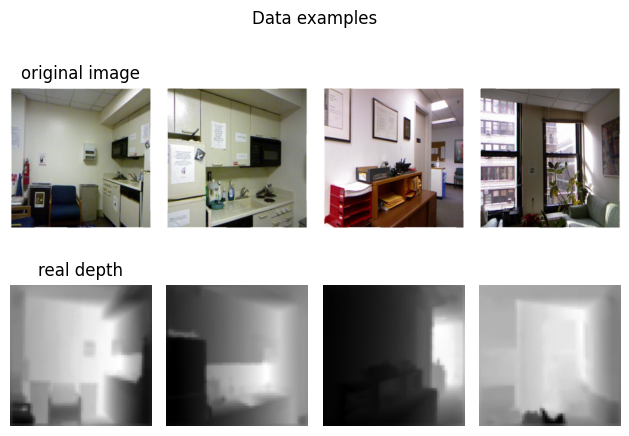

In [41]:
vis_data = NyuDataModule('/content/nyu_data/', 'data/nyu2_train.csv', 'data/nyu2_test.csv',
                         batch_size=4, apply_transforms=True)
vis_batch = next(iter(vis_data.test_dataloader()))
visualize('Data examples', vis_batch);

## Build model

* EfficientNetWrapper: A PyTorch Lightning module that uses an  EfficientNet model as a backbone for feature extraction. The layers of the EfficientNet model are accessed individually and saved as attributes of the wrapper class.

* BiFPN: A custom implementation of a bidirectional feature pyramid network (BiFPN). The BiFPN takes the features extracted from the EfficientNet and combines them at different scales to create a rich multi-scale feature representation. It employs convolutional layers, activation functions, batch normalization, and upsample operations, and has learnable weight parameters for feature fusion.

* Decoder: Another PyTorch module that uses the BiFPN for generating a set of feature maps. The feature maps are then concatenated and passed through batch normalization and activation.

* ConvBlock: A custom convolutional block that uses a depthwise convolution followed by a pointwise convolution, which is a common pattern in MobileNet architectures. The depthwise convolution applies a single filter per input channel, and the pointwise convolution applies a 1x1 convolution, combining the output of the depthwise filters.

* InceptionCore: It's an implementation of an inception module, a popular type of convolutional block that applies convolutions of different types and sizes to the same input, and concatenates the results. This allows the model to learn different types of features from the same input.



In [42]:
# Importing the required libraries and modules
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl

# Define a wrapper for the EfficientNet model
class EfficientNetWrapper(pl.LightningModule):
    # Initialize the EfficientNetWrapper class
    def __init__(self):
        # Call the parent's constructor
        super(EfficientNetWrapper, self).__init__()

        # Initialize EfficientNet with pre-trained weights from ImageNet
        self.efficientnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        # Define the base layers as the first three layers of EfficientNet
        self.base_layers = nn.Sequential(
            self.efficientnet.features[0],
            self.efficientnet.features[1],
            self.efficientnet.features[2],
        )

        # Define the subsequent layers
        self.layer1 = self.efficientnet.features[3]
        self.layer2 = nn.Sequential(
            self.efficientnet.features[4], self.efficientnet.features[5]
        )
        self.layer3 = self.efficientnet.features[6]
        self.layer4 = self.efficientnet.features[7]
        self.layer5 = self.efficientnet.features[8]

    # Define a function to get the feature maps from the model
    def get_features(self, x):
        # Pass the input through the base layers
        x = self.base_layers(x)

        # Pass the output of the base layers through each subsequent layer
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        # Return the output of each layer as a tuple
        return x1, x2, x3, x4, x5


#### BiFPN

The BiFPN class uses a combination of top-down and bottom-up pathways to aggregate multi-scale features in an efficient way. This helps in tasks like object detection and semantic segmentation, where it's important to capture features at different scales.

In [43]:
# Define a Bi-directional Feature Pyramid Network (BiFPN) module
class BiFPN(nn.Module):
    # Initialize the BiFPN class
    def __init__(self, fpn_sizes):
        # Call the parent's constructor
        super(BiFPN, self).__init__()

        # Unpack the FPN sizes for each layer
        P3_channels, P4_channels, P5_channels, P6_channels, P7_channels = fpn_sizes

        # Define the number of output channels for BiFPN
        self.W_bifpn = 64

        # Define the top-down pathway for P6
        self.p6_td_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_td_conv_2 = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_act = nn.ReLU()
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv = nn.Conv2d(
            P5_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p5_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_td_act = nn.ReLU()
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv = nn.Conv2d(
            P4_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p4_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_td_act = nn.ReLU()
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.p3_out_conv = nn.Conv2d(
            P3_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p3_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p3_out_act = nn.ReLU()
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.p4_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_out_act = nn.ReLU()
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample = nn.MaxPool2d(kernel_size=2)

        self.p5_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_out_act = nn.ReLU()
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample = nn.MaxPool2d(kernel_size=2)

        self.p6_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p6_out_act = nn.ReLU()
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p7_out_conv = nn.Conv2d(
            P7_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p7_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p7_out_act = nn.ReLU()
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

    # Define the forward pass
    def forward(self, inputs):
        epsilon = 0.0001  # Small number to prevent division by zero
        P3, P4, P5, P6, P7 = inputs  # Unpack the input feature maps
        P7_td = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2(
            (self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) / self.p6_td_w1
            + self.p6_td_w2
            + epsilon
        )
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)

        P5_td_inp = self.p5_td_conv(P5)
        P5_td = self.p5_td_conv_2(
            (self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td)
            / (self.p5_td_w1 + self.p5_td_w2 + epsilon)
        )
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2(
            (
                self.p4_td_w1 * P4_td_inp
                + self.p4_td_w2 * self.p5_upsample(P5_td)
            )
            / (self.p4_td_w1 + self.p4_td_w2 + epsilon)
        )
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)

        P3_td = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2(
            (self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td))
            / (self.p3_out_w1 + self.p3_out_w2 + epsilon)
        )
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        P4_out = self.p4_out_conv(
            (
                self.p4_out_w1 * P4_td_inp
                + self.p4_out_w2 * P4_td
                + self.p4_out_w3 * self.p3_downsample(P3_out)
            )
            / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon)
        )
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)

        P5_out = self.p5_out_conv(
            (
                self.p5_out_w1 * P5_td_inp
                + self.p5_out_w2 * P5_td
                + self.p5_out_w3 * self.p4_downsample(P4_out)
            )
            / (self.p5_out_w2 + self.p5_out_w3 + epsilon)
        )
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)

        P6_out = self.p6_out_conv(
            (
                self.p6_out_w1 * P6_td_inp
                + self.p6_out_w2 * P6_td
                + self.p6_out_w3 * (P5_out)
            )
            / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon)
        )
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)

        P7_out = self.p7_out_conv_2(
            (self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out)
            / (self.p7_out_w1 + self.p7_out_w2 + epsilon)
        )
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

#### Decoder

The Decoder class takes a set of feature maps as input, processes them through a BiFPN to aggregate multi-scale features, upsamples the resulting feature maps to increase their resolution, and applies batch normalization and an activation function. The output is a high-resolution feature map that has been enriched with multi-scale information from the input feature maps. This can be useful for tasks like image segmentation, where it's important to have a detailed understanding of the spatial structure of the input image.

In [44]:
# Define the Decoder class
class Decoder(nn.Module):
    # Initialize the Decoder class
    def __init__(self):
        # Call the parent's constructor
        super().__init__()

        # Create a BiFPN with specified channels for each level
        self.bifpn = BiFPN([40, 112, 192, 320, 1280])

        # Create upsampling layers, which will increase the resolution of the feature maps
        self.upsample1 = nn.PixelShuffle(2)
        self.upsample2 = nn.PixelShuffle(4)

        # Create a Batch Normalization layer, which will normalize the activations of the input volume
        self.bn = nn.BatchNorm2d(20)

        # Create an activation layer
        self.act = nn.ReLU()

    # Define the forward pass
    def forward(self, x):
        # Get the feature maps from the BiFPN
        x1, x2, _, _, _ = self.bifpn(x)

        # Upsample the feature maps
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)

        # Concatenate the upsampled feature maps along the channel dimension
        x = torch.cat([x1, x2], 1)

        # Normalize the activations and apply the activation function
        x = self.bn(x)
        x = self.act(x)

        # Return the final feature map
        return x


#### ConvBlock

The ConvBlock class implements a depthwise separable convolution, which is a type of convolution that can reduce computational complexity while maintaining model performance. This can be particularly useful for deploying models on devices with limited computational resources, such as mobile devices. The block first applies a depthwise convolution, which convolves each input channel separately, and then applies a pointwise convolution, which mixes the channels. Optionally, it can apply batch normalization and an activation function after the convolutions.

In [45]:
# Define the ConvBlock class
class ConvBlock(nn.Module):
    # Initialize the ConvBlock class
    def __init__(self, in_dims, out_dims, kernel_size=3, extras=True):
        # Call the parent's constructor
        super().__init__()

        # Create a depthwise convolutional layer, which convolves each input channel separately
        self.depth_conv = nn.Conv2d(in_dims, in_dims, kernel_size=kernel_size, padding=kernel_size//2, groups=in_dims)

        # Create a pointwise convolutional layer (1x1 convolution), which mixes the input channels
        self.point_conv = nn.Conv2d(in_dims, out_dims, kernel_size=1)

        # Create a Batch Normalization layer, which normalizes the activations of the input volume
        # Create an activation layer
        # If extras is False, these will not be created
        self.bn = nn.BatchNorm2d(out_dims) if extras else None
        self.act = nn.RELU() if extras else None

    # Define the forward pass
    def forward(self, x):
        # Pass the input through the depthwise convolution
        x = self.depth_conv(x)

        # Pass the output through the pointwise convolution
        x = self.point_conv(x)

        # If bn is not None, apply Batch Normalization and activation
        if self.bn:
            x = self.bn(x)
            x = self.act(x)

        # Return the final output
        return x


### InceptionCore

his class implements a variant of the Inception module, which is a building block of the Inception (or GoogLeNet) model, an award-winning model from the ImageNet Large-Scale Visual Recognition Challenge 2014. The module applies several different convolutions to the same input and concatenates their outputs, allowing the model to learn different types of features simultaneously. Here, the branches perform different types of convolutions (1x1, 3x3, 1x3, and 3x1) to capture different spatial features in the input.

In [46]:
# Define the InceptionCore class
class InceptionCore(nn.Module):
    # Initialize the InceptionCore class
    def __init__(self, in_dims, base=16):
        # Call the parent's constructor
        super().__init__()

        # Define convolution layers for first branch, for 1x1, 3x3, 1x3 and 3x1 convolutions
        self.branch_1_1 = nn.Conv2d(in_dims, base, 1)
        self.branch_1_3 = nn.Conv2d(base, base*2, 3, padding=1)
        self.branch_1_13 = nn.Conv2d(base*2, base*3, (1,3), padding=(0,1))
        self.branch_1_31 = nn.Conv2d(base*2, base*3, (3,1), padding=(1,0))

        # Define convolution layers for second branch, for 1x1, 1x3 and 3x1 convolutions
        self.branch_2_1 = nn.Conv2d(in_dims, base, 1)
        self.branch_2_13 = nn.Conv2d(base, base*2, (1,3), padding=(0,1))
        self.branch_2_31 = nn.Conv2d(base, base*2, (3,1), padding=(1,0))

        # Define convolution layer for third branch, for 1x1 convolution
        self.branch_3_1 = nn.Conv2d(in_dims, base, 1)

        # Define downsample layer to bring all branches to the same depth
        self.downsample = nn.Conv2d(in_dims, base*11, 1, bias=False)

    # Define the forward pass
    def forward(self, x):
        # Process the input through the first branch
        branch_1 = self.branch_1_1(x)
        branch_1 = self.branch_1_3(branch_1)
        branch_1_1 = self.branch_1_13(branch_1)
        branch_1_2 = self.branch_1_31(branch_1)

        # Process the input through the second branch
        branch_2 = self.branch_2_1(x)
        branch_2_1 = self.branch_2_13(branch_2)
        branch_2_2 = self.branch_2_31(branch_2)

        # Process the input through the third branch
        branch_3 = self.branch_3_1(x)

        # Downsample the input to match the depth of other branches
        res = self.downsample(x)

        # Concatenate all the branches along the depth dimension
        x = torch.cat([branch_1_1, branch_1_2, branch_2_1, branch_2_2, branch_3], dim=1)

        # Add the downsampled input to the output
        x += res

        # Return the output
        return x


#### DepthNet

This class is a neural network for depth estimation tasks. It uses the EfficientNet architecture to encode the input, and then three parallel decoders to decode the features. The outputs of the decoders are concatenated and added to a downsampled version of the input, introducing a residual connection. The result is then processed by the head of the network, which includes an Inception module and two convolution blocks, and finally passed through a ReLU6 activation function.

In [47]:
# Define the DepthNet class
class DepthNet(nn.Module):
    # Initialize the DepthNet class
    def __init__(self):
        # Call the parent's constructor
        super().__init__()
        # Initialize the encoder with EfficientNet
        self.encoder = EfficientNetWrapper()
        # Uncomment the following line to freeze the encoder parameters
        # self.encoder.freeze()
        # Initialize three decoders
        self.d1 = Decoder()
        self.d2 = Decoder()
        self.d3 = Decoder()
        # Initialize a downsample layer to downsample the input
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 60, 1, bias=False),  # Convolution layer to increase the depth of the input
            nn.MaxPool2d(4)  # Max pooling to downsample the spatial dimensions
        )
        # Initialize the head of the network, which processes the output of the decoders
        self.head = nn.Sequential(
            InceptionCore(60),  # Inception module to extract complex features
            ConvBlock(176, 40),  # Convolution block to further process the features
            ConvBlock(40, 1, extras=False),  # Convolution block to reduce the depth to 1
        )
        # Initialize the activation function
        self.act = nn.ReLU6()

    # Define the forward pass
    def forward(self, x):
        # Downsample the input and store it in res1
        res1 = self.downsample(x)
        # Extract features from the input using the encoder
        x = self.encoder.get_features(x)
        # Process the features through the decoders
        x1 = self.d1(x)
        x2 = self.d2(x)
        x3 = self.d3(x)
        # Concatenate the outputs of the decoders along the depth dimension
        x = torch.cat([x1, x2, x3], 1)
        # Add the downsampled input to the output
        x += res1
        # Process the output through the head of the network
        x = self.head(x)
        # Apply the activation function
        x = self.act(x)
        # Return the output
        return x


# Module definition

This class, LitDepth, is a custom PyTorch Lightning module. It uses the DepthNet for depth estimation. The forward method is defined to perform a forward pass of the network. The _do_stuff method performs common operations for training, validation and testing. These operations include computing the network's estimations, calculating the accuracy and the loss, and logging these metrics. The training_step, validation_step and test_step methods use this common method. Finally, the configure_optimizers method defines the optimizer to be used for training.

In [48]:
# Define a custom PyTorch Lightning module for the depth estimation task
class LitDepth(pl.LightningModule):
    # Initialize the Lightning module
    def __init__(self, learning_rate=2e-3, weight_decay=1e-4):
        # Call the parent's constructor
        super(LitDepth, self).__init__()
        # Save the hyperparameters
        self.save_hyperparameters()
        # Initialize the depth estimation network
        self.net = DepthNet()
        # Initialize the loss function
        self.loss = torch.nn.MSELoss()
        # Initialize the accuracy metric as structural similarity index measure
        self.accuracy = StructuralSimilarityIndexMeasure(data_range=1.0)

    # Define the forward pass
    def forward(self, x):
        # Feed the input through the network
        x = self.net(x)
        return x

    # Define a common method for training, validation and testing
    def _do_stuff(self, batch, name):
        # Split the batch into inputs and targets
        x, y = batch
        # Get the network's estimations
        estimated = self(x)
        # Compute the accuracy
        acc = self.accuracy(estimated, y)
        # Log the accuracy
        self.log(f'{name}_acc', acc)
        # Compute the loss
        loss = self.loss(estimated, y)
        # Log the loss
        self.log(f'{name}_loss', loss)
        # Return the loss
        return loss

    # Define the training step
    def training_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'train')

    # Define the validation step
    def validation_step(self, batch, _batch_idx):
        loss = self._do_stuff(batch, 'validation')
        # Log the validation loss for hyperparameter optimization
        self.log('hp_metric', loss)
        return loss

    # Define the testing step
    def test_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'test')

    # Define the optimizer
    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        wd = self.hparams.weight_decay
        # Initialize the Adam optimizer with the learning rate and weight decay from the hyperparameters
        optimizer = Adam(self.parameters(), lr=lr, weight_decay=wd)
        # Return the optimizer
        return optimizer


# Training

## Image callback

In [49]:
# Define a custom PyTorch Lightning callback for image sampling
class ImageSampler(pl.callbacks.Callback):
    # Initialize the ImageSampler callback
    def __init__(
        self,
        num_samples: int = 3,
        nrow: int = 8,
        padding: int = 2,
        normalize: bool = True,
        norm_range = None,
        scale_each: bool = False,
        pad_value: int = 0,
    ) -> None:
        """
        Args:
            num_samples: Number of images displayed in the grid. Default: ``3``.
            nrow: Number of images displayed in each row of the grid.
                The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
            padding: Amount of padding. Default: ``2``.
            normalize: If ``True``, shift the image to the range (0, 1),
                by the min and max values specified by :attr:`range`. Default: ``False``.
            norm_range: Tuple (min, max) where min and max are numbers,
                then these numbers are used to normalize the image. By default, min and max
                are computed from the tensor.
            scale_each: If ``True``, scale each image in the batch of
                images separately rather than the (min, max) over all images. Default: ``False``.
            pad_value: Value for the padded pixels. Default: ``0``.
        """
        super().__init__()
        # Save the parameters
        self.num_samples = num_samples
        self.nrow = nrow
        self.padding = padding
        self.normalize = normalize
        self.norm_range = norm_range
        self.scale_each = scale_each
        self.pad_value = pad_value

    # Define a method to convert a batch of images to a grid for visualization
    def to_grid(self, images):
        return make_grid(
            tensor=images,
            nrow=self.nrow,
            padding=self.padding,
            normalize=self.normalize,
            range=self.norm_range,
            scale_each=self.scale_each,
            pad_value=self.pad_value,
        )

    # Define a method to be called at the start of fit
    def on_fit_start(self, trainer, pl_module):
        # Get the logger from the module
        logger = pl_module.logger.experiment
        # Get a batch of images and their ground truths from the validation set
        images, ground_truth = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # Log the images and their ground truths
        logger.add_images("original images", images)
        logger.add_images("real depth", ground_truth)

    # Define a method to be called at the end of each validation epoch
    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        # Get the logger from the module
        logger = pl_module.logger.experiment
        # Get a batch of images and their targets from the validation set
        images, targets = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # Generate the depth estimations
        estimated = pl_module(images.to(pl_module.device)).detach()
        # Log the estimated depths
        logger.add_images("estimated depth", estimated, trainer.current_epoch)

    # Define a method to be called at the end of each test epoch
    def on_test_epoch_end(self, trainer, pl_module) -> None:
        # Get the logger from the module
        logger = pl_module.logger.experiment
        # Get a batch of images and their targets from the test set
        images, targets = next(iter(DataLoader(trainer.datamodule.test, batch_size=self.num_samples)))
        # Generate the depth estimations
        estimated = pl_module(images.to(pl_module.device)).detach()
        # Log the test images and their estimated depths
        logger.add_images("test images", images)
        logger.add_images("test estimation", estimated)


## Experiment definitions

In [50]:
experiments = [
    {
        # Experiment 1
        'name': 'low_lr_with_augs', 'lr': 1e-4, 'augs': True
    },
    {
        # Experiment 2
        'name': 'mid_lr_with_augs', 'lr': 1e-3, 'augs': True
    },
    {
        # Experiment 3
        'name': 'high_lr_with_augs', 'lr': 1e-2, 'augs': True
    },
    {
        # Experiment 4
        'name': 'without_augs', 'lr': 1e-3, 'augs': False
}
    ]

## Trainer Definition

In [51]:
def run_experiment(name, lr, augs):
    early_stop_callback = pl.callbacks.EarlyStopping(
        monitor='validation_loss',
        min_delta=1e-3,
        patience=4,
        mode='min',
        verbose=True
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/content/gdrive/MyDrive/Colab Notebooks/ENNCA/record/',
        filename=f'best_model_{name}',
        save_top_k=1,
        monitor='validation_loss',
        mode='min',
    )

    tb_logger = pl.loggers.TensorBoardLogger(
        save_dir='/content/gdrive/MyDrive/Colab Notebooks/ENNCA/',
        name='tb_logs',
        version=name
    )

    data = NyuDataModule(
        root='/content/nyu_data/',
        csv_train='data/nyu2_train.csv',
        csv_test='data/nyu2_test.csv',
        batch_size=32,
        apply_transforms=augs
    )

    model = LitDepth(learning_rate = lr)

    trainer = pl.Trainer(
        default_root_dir='/content/gdrive/MyDrive/Colab Notebooks/ENNCA/',
        callbacks=[
            early_stop_callback,
            checkpoint_callback,
            ImageSampler(),
            pl.callbacks.LearningRateMonitor(),
            pl.callbacks.ModelSummary(),
        ],
        max_epochs=15,
        precision=16,
        logger=tb_logger,
        gradient_clip_val=0.5,
        # limit_train_batches=8,
        # limit_test_batches=8,
        # limit_val_batches=8,
        # detect_anomaly=True,
        # fast_dev_run=True,
        # profiler="simple"
    )

    print('Starting training...')
    trainer.fit(model, datamodule=data)

    print('Starting testing...')
    trainer.test(model, datamodule=data)

    model.eval()
    model.freeze()
    visualize(f'{name} estimation', vis_batch, model);

# Runs

In [ ]:
for (i, exp) in enumerate(experiments):
    print(f'Running experiment {i+1}/{len(experiments)}:', exp)
    run_experiment(**exp)

Running experiment 1/4: {'name': 'low_lr_with_augs', 'lr': 0.0001, 'augs': True}


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting training...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/gdrive/MyDrive/Colab Notebooks/ENNCA/record exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 8.7 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.830    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved. New best score: 0.013
